In [3]:
import numpy as np
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import gymnasium as gym
import gym_bart
from plotting_utils import (
    set_rc, 
    rgb_colors
)

import sys
sys.path.append('../')
import pickle

from bart_representation_analysis import *
from bart_compress_visualize_decode import *
from bart_single_node_responses import *

set_rc()

# How to use these files

The main analysis functions come from 3 files:
- bart_representation_analysis.py
- bart_compress_visualize_decode.py
- bart_single_node_responses.py

There are also a bunch of jupyter notebooks that you could look at to see how functions are used, but most of these are pretty unorganized so may be hard to follow.

**Hint: if you're using VSCode, usually you can Ctrl+click a function and it will take you to the definition to see what it does and where it is**

## Agent training conditions

3 main conditions
1. Whether agent is shown reward or not (0: reward shown, 1: not shown)
2. Punishment given for pops (0, 0.1, 0.2, 0.4)
3. Reward shape where $r = s^p$, r is reward, s is the size of banked balloon, p is shaping variable (1, 1.2, 1.5, 1.7, 2)
4. Also we have 10 agents trained for each condition

Hence each agent has a 4-tuple index defining it, e.g. 

(0, 2, 1, 3): Agent shown reward, 0.2 punishment, 1.2 reward shape, trial number 4

## Main evaluation pipeline

We already have trained agents in the saved_checkpoints folder. The basic outline to analyze an agent is
1. Load the agent
2. Have the agent run its behavior while recording its activations and analyze them
3. We also have the option of testing the agent by feeding specific observations and stimul and also recording activations

### Loading agents

2 main functions for loading agents, metabart_model_load() and select_random_model()

In [11]:
# When loading a model, we always get both the model (the neural network) and
#  obs_rms, which is used during training to record the observations seen
#  by the agent to normalize observations with
idx = (0, 2, 1, 3)
model, obs_rms = metabart_model_load(idx)

# select_random_model selects a random index with largest values per entry of
#  (1, 3, 4, 9) corresponding to the agent training condition and trial
rand_idx = select_random_model()

### Testing agents

The main function we use to test a loaded model is evalu()

In [17]:
# When evaluating, we have to tell is whether to give the reward info since
#  that will change the observations 
give_rew = idx[0] == 0
res = evalu(model, obs_rms, give_rew=give_rew)

# This evaluation function tests the agent on 17 episodes with balloon sizes
#  ranging from 0.2 to 1.0
print('Tested sizes', size)

c:\Users\14and\anaconda3\envs\bart\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.balloon_mean_sizes to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.balloon_mean_sizes` for environment variables or `env.get_wrapper_attr('balloon_mean_sizes')` that will search the reminding wrappers.
  logger.warn(


Tested sizes [0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7  0.75 0.8  0.85
 0.9  0.95 1.  ]


In [18]:
# The results come back as a dictionary organized by episode corresponding to 
#  balloon size
res.keys()

dict_keys(['obs', 'actions', 'action_log_probs', 'action_probs', 'rewards', 'rnn_hxs', 'dones', 'masks', 'values', 'data', 'activations'])

In [ ]:
# Observations from the 5th episode, which lasted 454 steps
res['obs'][5].shape

(454, 9)

In [ ]:
# Activations in layer 'shared1' correspond to the RNN layer output
res['activations']['shared1'][5].shape

torch.Size([454, 64])

# Stimulus Experiments

A main experiment we're testing is to first give 50 balloons of size 0.5, then 1 balloon of a variable size (0.2-0.8), then go back to the reference 0.5 size and check how each node responds. Here we use the perform_stimuli_experiment() function, which generates these experiments

[SubplotGrid(nrows=1, ncols=5, length=5),
 SubplotGrid(nrows=1, ncols=1, length=1)]

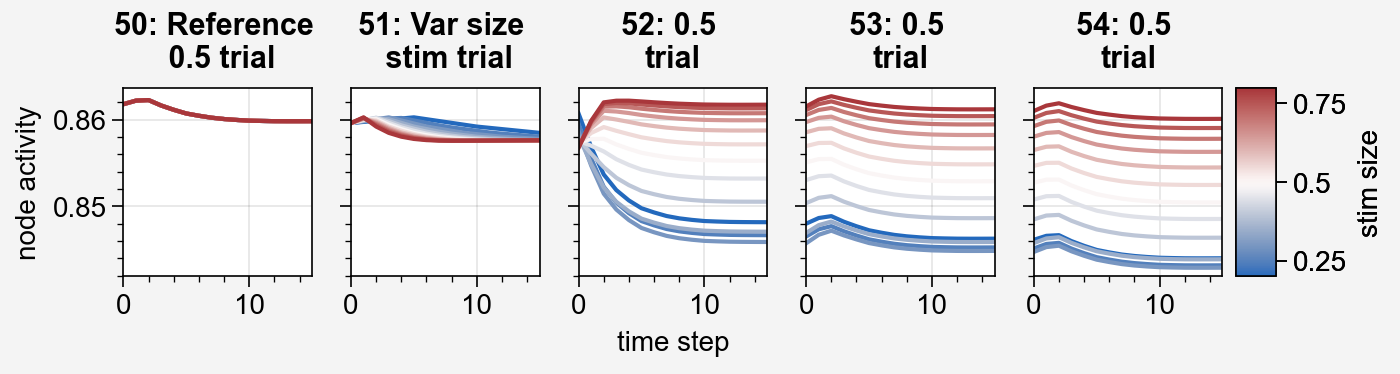

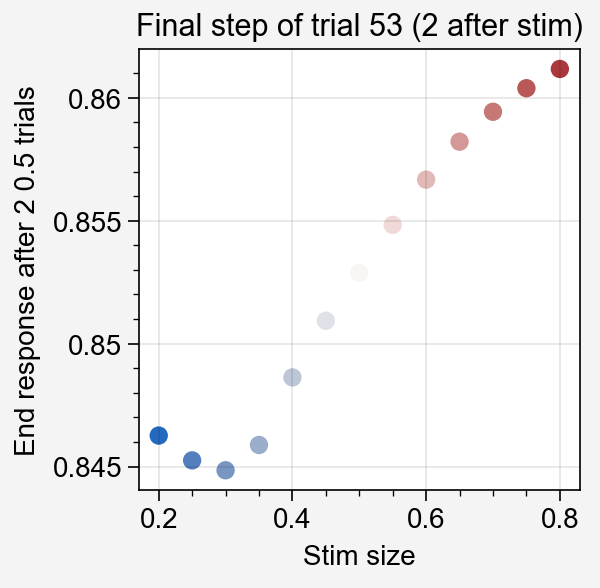

In [ ]:
idx = (0, 2, 1, 5)
give = idx[0] == 0
# Note select_random_model has helpful functions to load the model and run evalu too
_, model, obs_rms, r = select_random_model(idx=idx, load_models=True)
responses, stim_sizes = perform_stimuli_experiment(model, obs_rms, give=give, stim_sizes=1, 
                                                   refsize=0.5)
plot_fixed_stimulus_experiment(responses, 8)

In [ ]:
# Note responses is given by responses[m, n, i, t]
#  m: size of variable stimulus (0.2, 0.25,... 1)
#  n: stimulus number (variable stimulus happens at idx 50, we check response at 52)
#  i: node number (RNN has 64 nodes)
#  t: time step number (balloon starts at 0, banked at 15, note that the function
#   stimuli_responses does some interpolation/stretching to make all trials take the
#   same number of steps for easier plotting)
responses.shape

(13, 71, 64, 16)

[SubplotGrid(nrows=1, ncols=5, length=5),
 SubplotGrid(nrows=1, ncols=1, length=1)]

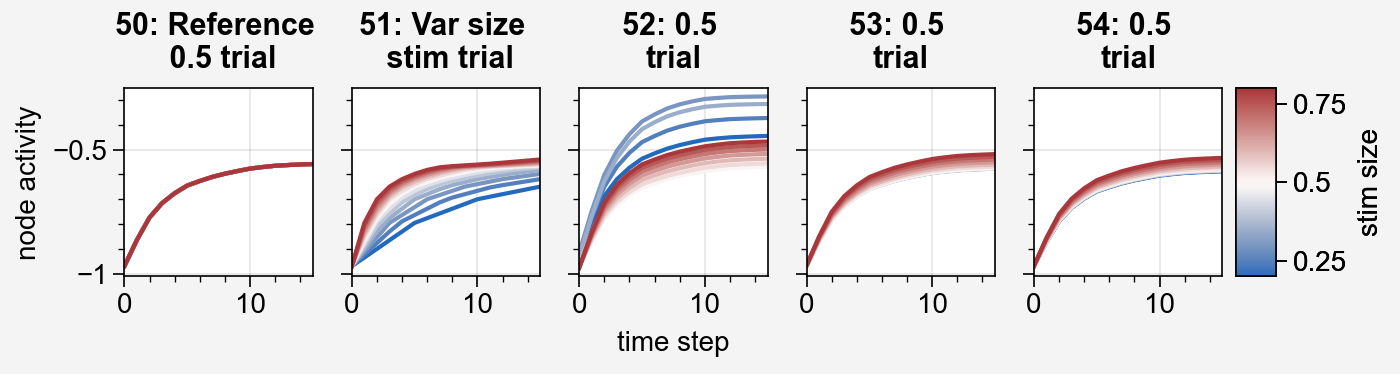

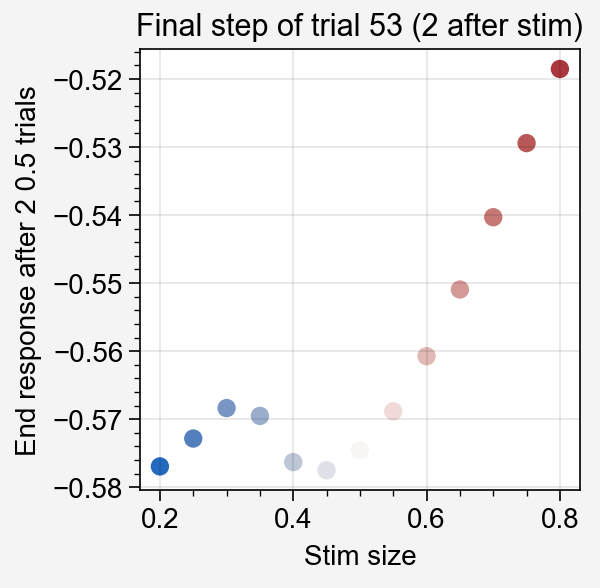

In [ ]:
n = 17
# The plotting function helps visualize how node n responds
plot_fixed_stimulus_experiment(responses, n)

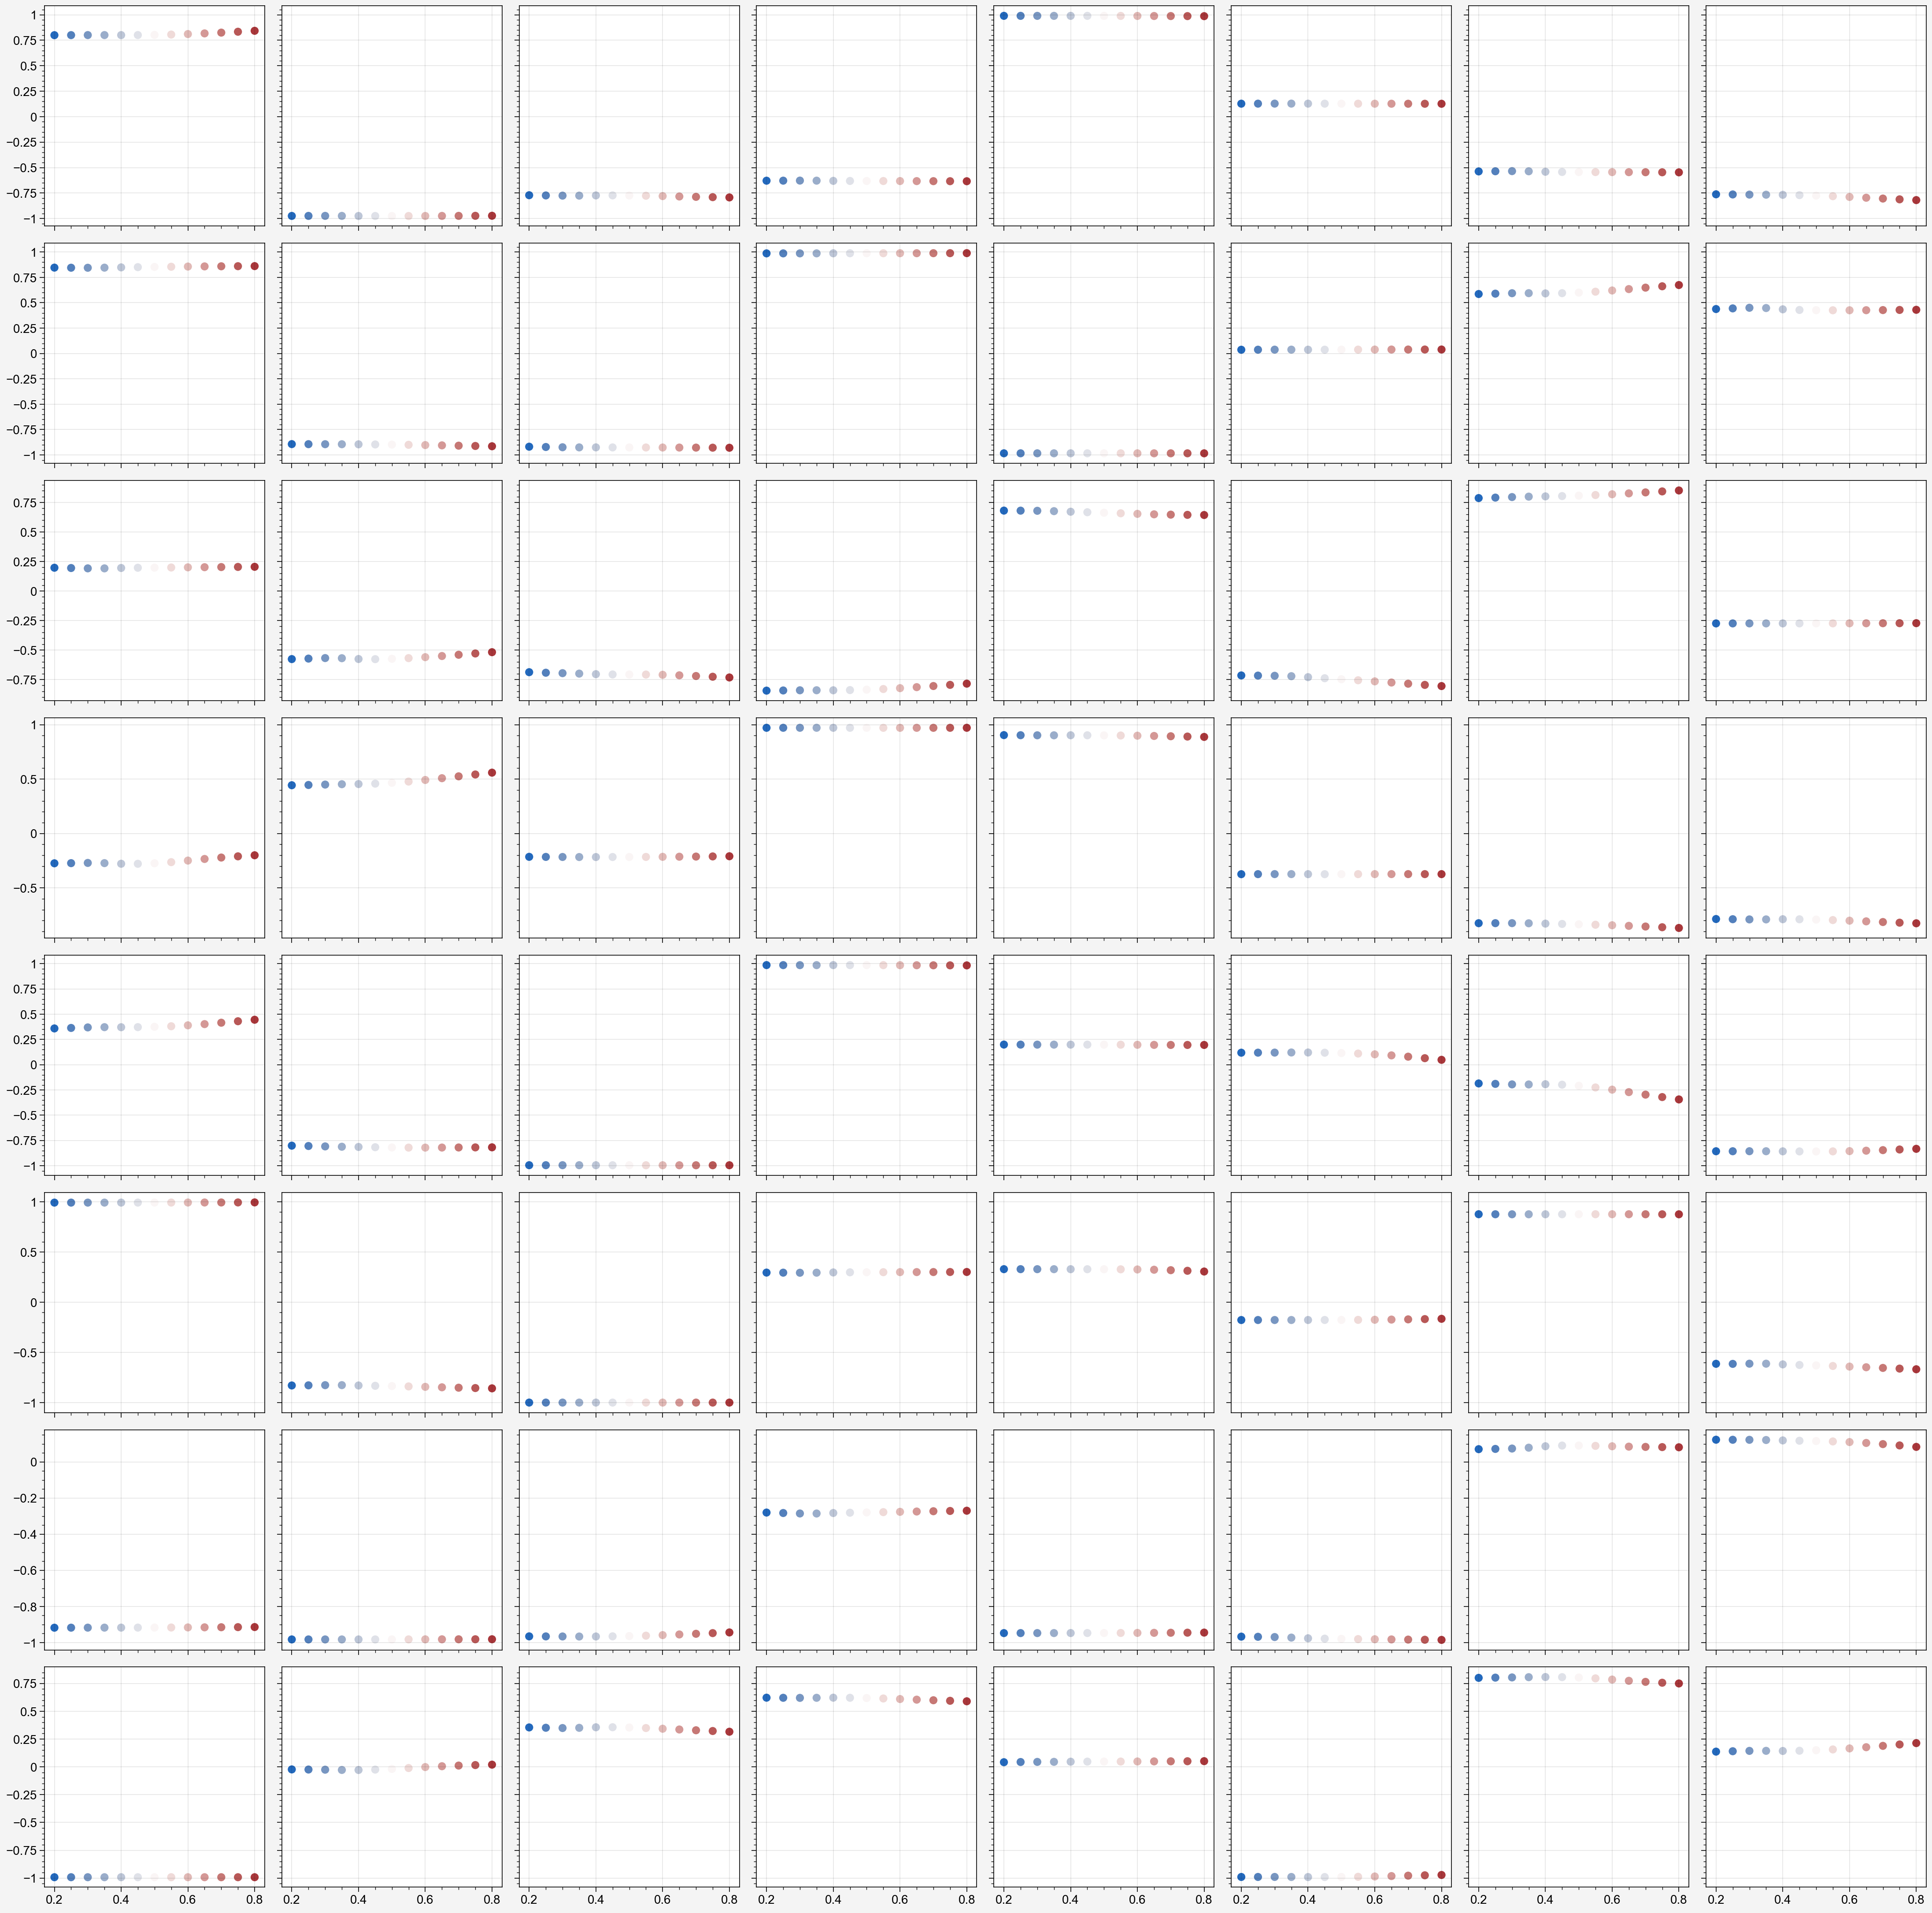

In [ ]:
# We can also manually visualize all of the end responses at trial 52,
#  noting trial 50 is the variable stimulus trial
fig, ax = pplt.subplots(nrows=8, ncols=8)
for n in range(64):
    ax[n].scatter(stim_sizes, responses[:, 52, n, -1], c=stim_sizes,
                  cmap='vlag')

# Measuring Gradient Influences

In addition to measuring how nodes respond to variable stimuli, we also want to know how they influence the value and action outputs of the agent.

Note that the action "press button" is action index 1. It might be interesting to see whether any of these nodes influence the press button probability strongly, but it's harder to think about than increasing/decreasing value prediction

In [ ]:
# Think through whether this function actually makes sense for what it says it does
action_grad = compute_gradient_influences(model, res, test='value')

In [ ]:
# Thinking of another way to record the "optimisticness" of a node
#  Get the mean activation of a node at step 52, for each variable stimulus
#  Subtract the mean activation under var stim by the mean activation under ref stimulus
step2_changes = responses[:, 52].mean(axis=2)
stim_sizes = np.round(np.arange(0.2, 0.81, 0.05), 2)
ref_size = 0.5
refidx = np.argwhere(stim_sizes == ref_size).squeeze()
step2_rel_changes = step2_changes - step2_changes[refidx]

In [ ]:
# step2_rel_changes[m, i] is the relative change in response of node i under var stim m
step2_rel_changes.shape

(13, 64)

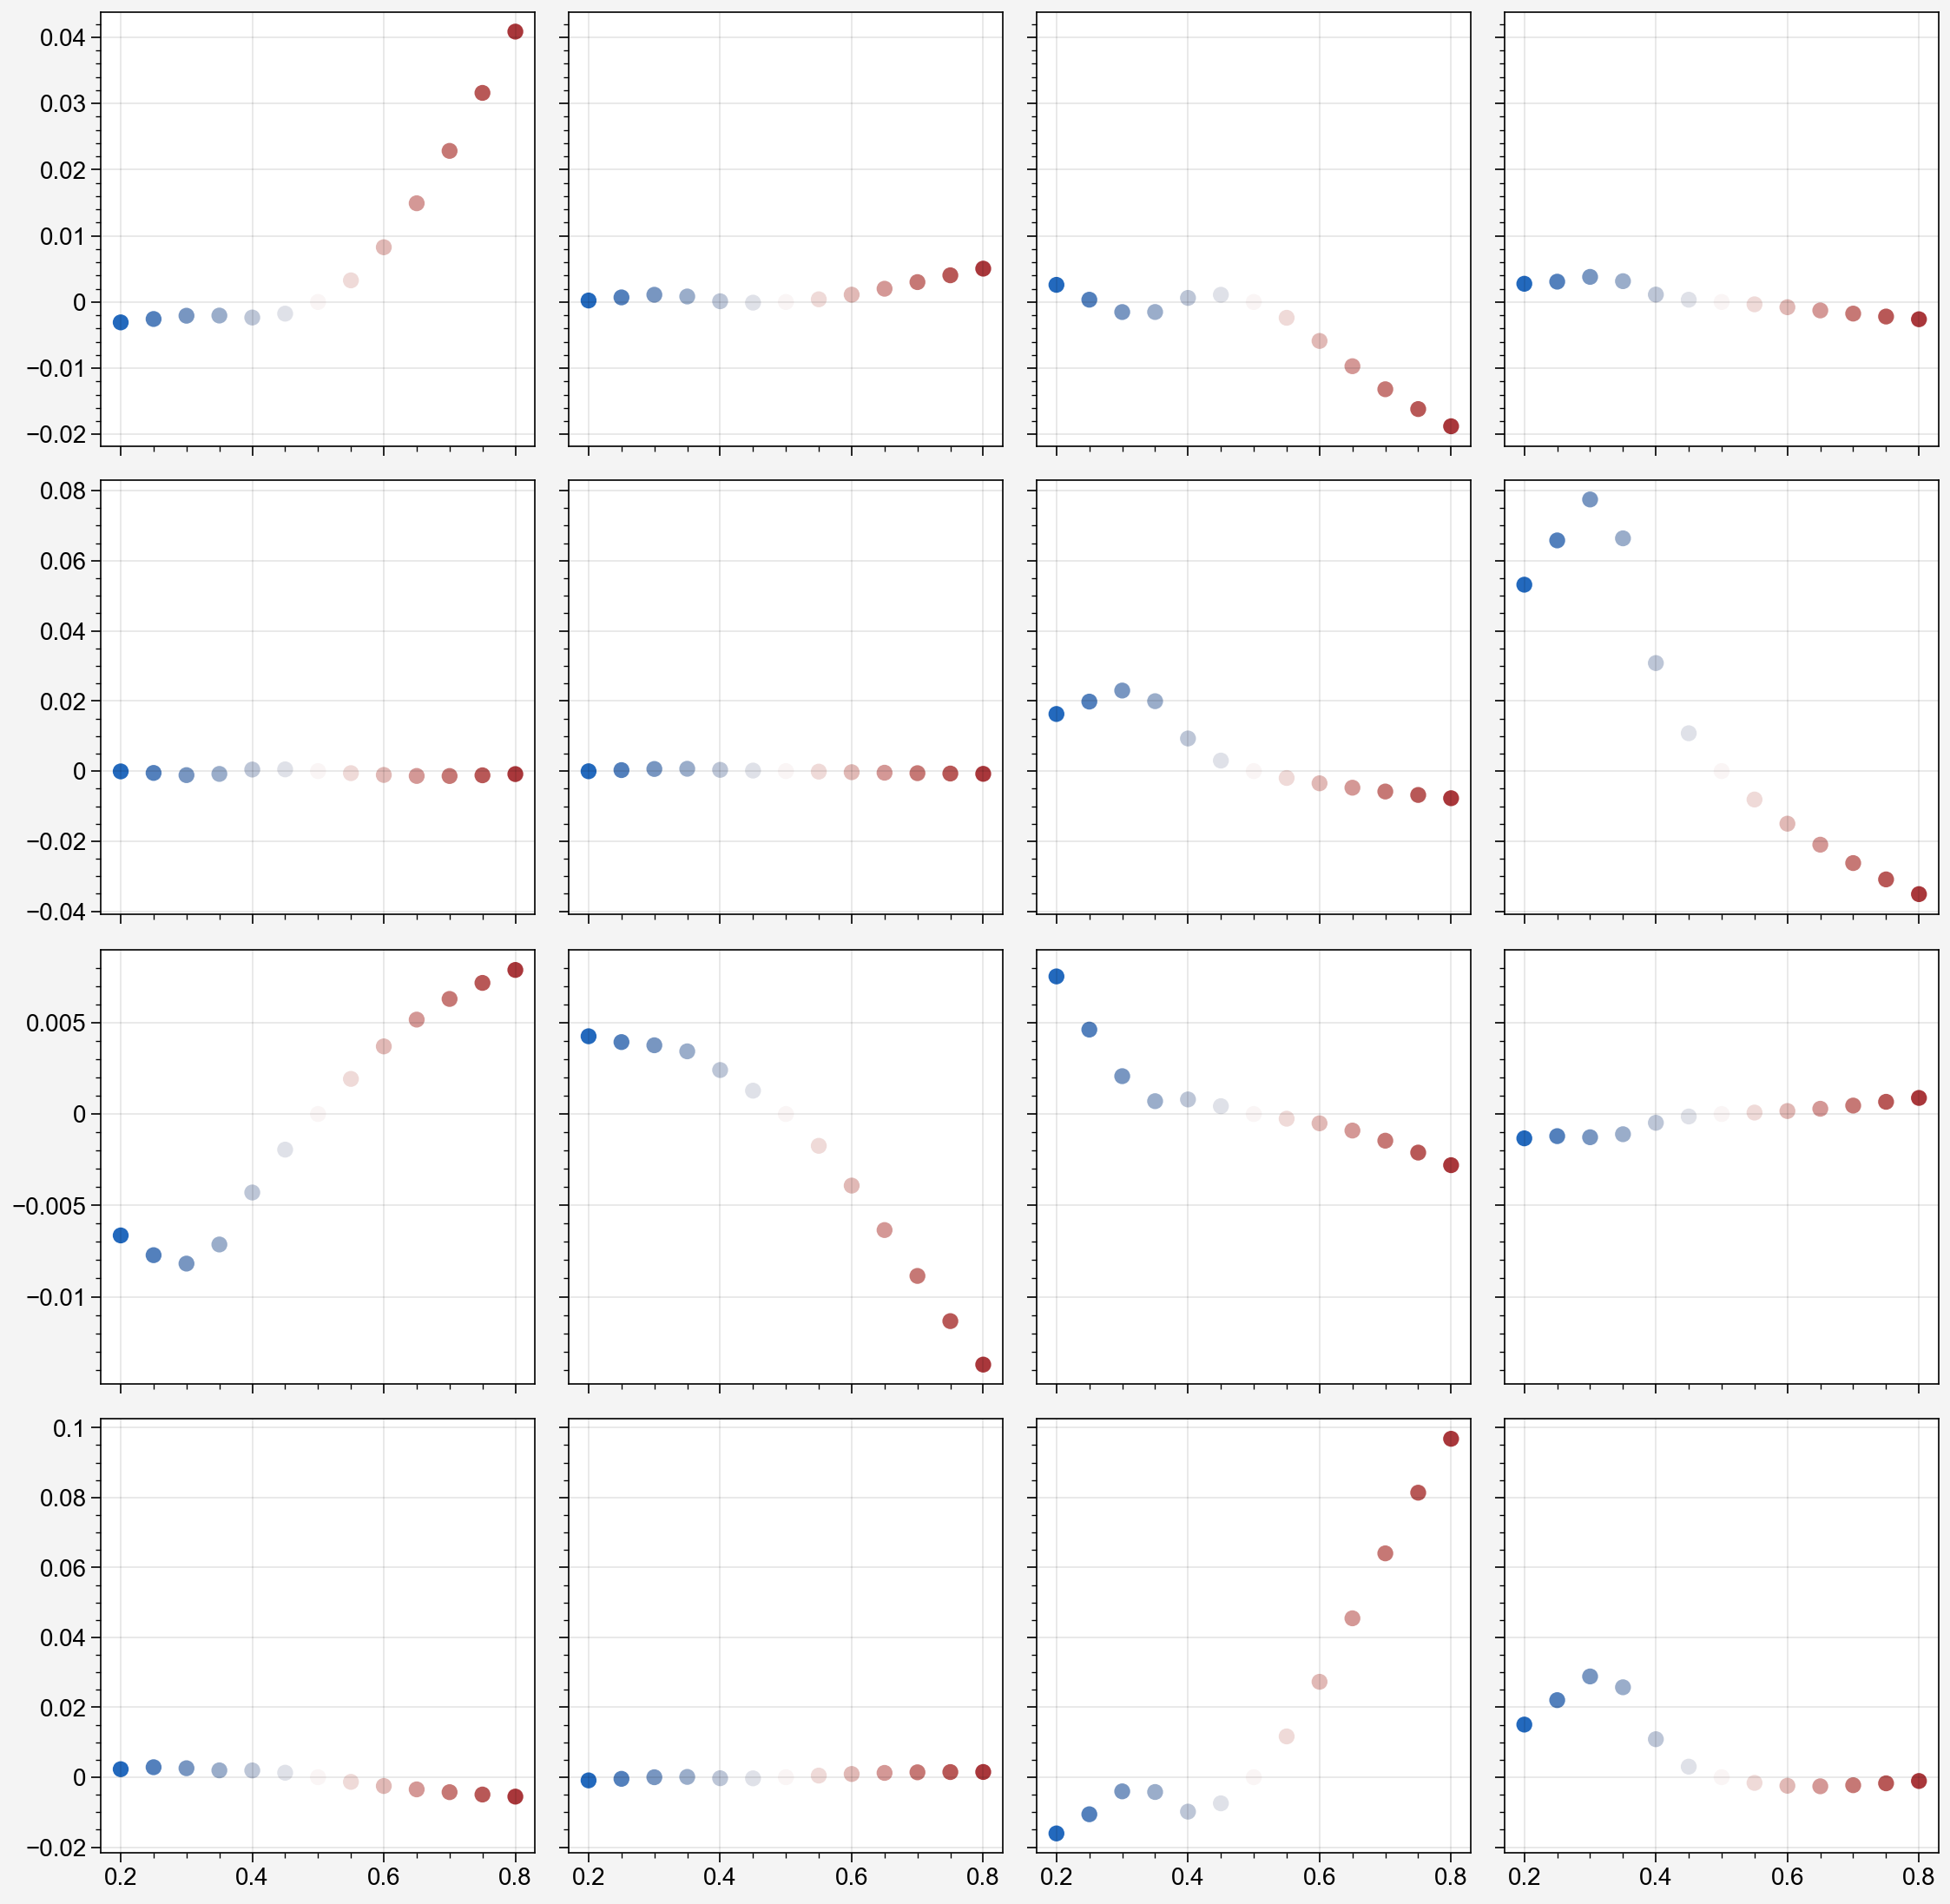

In [46]:
fig, ax = pplt.subplots(ncols=4, nrows=4)
for n in range(16):
    ax[n].scatter(stim_sizes, step2_rel_changes[:, n], 
                  c=stim_sizes, cmap='vlag')

# Agent Types

Finally, this summary file has a some information about the agents, but importantly has what I have labelled as their agent types (0/1/2), as well as some clustering labels kind of showing what type of nodes there are (0/1/2/3/4/5)

If we find interesting things about each node/agent's optimistic/pessimistic qualities, it would be good to compare this with the node/agent type.

In [62]:
summary = pickle.load(open('data/meta_summary', 'rb'))

In [ ]:
summary['agent_types'].shape # Agent Type (0/1/2)

(2, 4, 5, 10)

In [63]:
summary['node_meta_labels'].shape # Node type (0/1/2/3/4/5)

(2, 4, 5, 10, 64)

# Tasks

1. Familiarize yourself with the code
2. Make sure that the stimulus experiments and gradient influence functions make sense, try to walk through the code and see what they are doing - in particular the gradient influence function is new so I don't have much validation on its usage
3. Try to visualize a bunch of things, get a sense of how nodes respond to this variable stimulus experiment, maybe make some histograms, but generally the more time spent exploring data on an individual agent level as opposed to looking at a bunch of agents, the better things turn out
4. Maybe play around with different reference stimuli size. I was finding that at higher reference size (>0.6-0.7) all nodes reset very quickly back after the variable stimulus. Most agents really don't push balloons above 0.5-0.6 much, so maybe after seeing a 0.7 balloon for example, they forego any long-term memory and just try to replicate the 0.7 they saw